# Attention 相关代码实现

- Self Attention
- [X] Causual Attention
- Multi Head Attention
- MHA with KV-Cache
- MQA
- GQA

**Reference**
- https://github.com/rasbt/LLMs-from-scratch/blob/main/ch03/01_main-chapter-code/ch03.ipynb
- https://zhuanlan.zhihu.com/p/671319689
- https://hwcoder.top/Manual-Coding-1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

### Self Attention

In [2]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.w_q = nn.Linear(hidden_size, hidden_size)
        self.w_k   = nn.Linear(hidden_size, hidden_size)
        self.w_v = nn.Linear(hidden_size, hidden_size)

    def forward(self, hidden_states, mask=None):
        # hidden_states 形状: (batch_size, seq_len, hidden_size)
        
        # 计算注意力分数
        # key.transpose(-1, -2) 将最后两个维度进行转置，以进行点积
        # attention_scores 形状: (batch_size, seq_len, seq_len)
        batch_size, d_k = hidden_states.size(0), hidden_states.size(-1)        # 获取 hidden_size, batch_size
        
        # 计算 Q、K、V，线性变换
        query = self.w_q(hidden_states)  # (batch_size, seq_len, hidden_size)
        key = self.w_k(hidden_states)    # (batch_size, seq_len, hidden_size)
        value = self.w_v(hidden_states)  # (batch_size, seq_len, hidden_size)

        # 计算注意力分数，使用缩放点积注意力机制
        # attention_scores 形状: (batch_size, num_heads, seq_len, seq_len)
        # scores = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(d_k)
        scores = query @ key.transpose(-1, -2) / math.sqrt(d_k)
        
        # 添加注意力掩码（seq_len, seq_len），掩码位置（0）的值为负无穷
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
                
        # 对注意力分数进行归一化，得到注意力概率
        p_attn = scores.softmax(dim=-1)  # (batch_size, num_heads, seq_len, seq_len)
        
        # 计算注意力输出，通过注意力概率加权值
        output = torch.matmul(p_attn, value)  # (batch_size, num_heads, seq_len, hidden_size)
        
        return output


def test_attn():
    batch_size = 128
    seq_len = 512
    hidden_size = 1024
    
    hidden_states = torch.randn(batch_size, seq_len, hidden_size)  # (batch_size, seq_len, hidden_size)

    sdpa = ScaledDotProductAttention(hidden_size)
    output = sdpa(hidden_states)
    
    print("hidden_states shape:", hidden_states.shape)
    print("Output shape:", output.shape)
    
test_attn()

hidden_states shape: torch.Size([128, 512, 1024])
Output shape: torch.Size([128, 512, 1024])


### Multi Head Attention

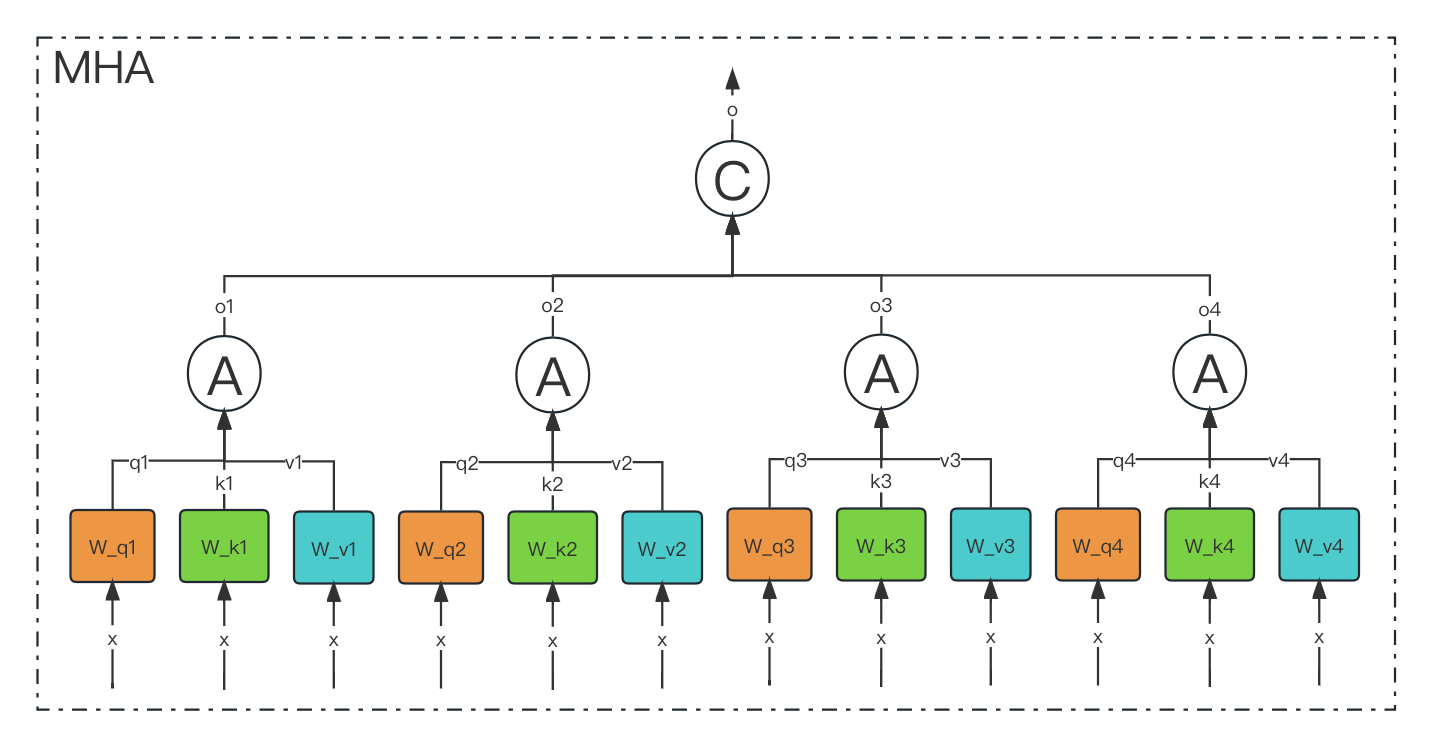

In [3]:
class MHA(nn.Module):
    def __init__(self, hidden_size, num_heads, p_dropout=0.1):
        super().__init__()
        assert hidden_size % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads  # 每个头的维度，二者必须整除
        
        self.w_q = nn.Linear(hidden_size, hidden_size)
        self.w_k   = nn.Linear(hidden_size, hidden_size)
        self.w_v = nn.Linear(hidden_size, hidden_size)
        self.w_out = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(p=p_dropout)

    def forward(self, hidden_states, mask=None):
        # hidden_states 形状: (batch_size, seq_len, hidden_size)
        
        batch_size, seq_len, _ = hidden_states.size()       # 获取 hidden_size, batch_size
        
        # 计算 Q、K、V，线性变换
        query = self.w_q(hidden_states).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)    # (batch_size, num_head, seq_len, head_dim)
        key = self.w_k(hidden_states).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)      # (batch_size, num_head, seq_len, head_dim)
        value = self.w_v(hidden_states).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)    # (batch_size, num_head, seq_len, head_dim)
        
        # qk
        # attention_scores 形状: (batch_size, num_heads, seq_len, seq_len)
        scores = query @ key.transpose(-1, -2) / math.sqrt(self.head_dim) 
        
        # attention mask
        # 添加注意力掩码（seq_len, seq_len），掩码位置（0）的值为负无穷
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # softmax
        # 对注意力分数进行归一化，得到注意力概率
        p_attn = scores.softmax(dim=-1)  # (batch_size, num_heads, seq_len, seq_len)
        p_attn = self.dropout(p_attn)    # dropout
        
        # qkv
        # 计算注意力输出，通过注意力概率加权值
        x = p_attn @ value
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(batch_size, -1, self.head_dim * self.num_heads)
        )
        # x = x.permute(0, 2, 1, 3).contiguous()
        
        del query, key, value
        
        return self.w_out(x)


def test_attn():
    batch_size = 128
    seq_len = 512
    hidden_size = 1024
    
    hidden_states = torch.randn(batch_size, seq_len, hidden_size)  # (batch_size, seq_len, hidden_size)

    sdpa = MHA(hidden_size, 8)
    output = sdpa(hidden_states)
    
    print("hidden_states shape:", hidden_states.shape)
    print("Output shape:", output.shape)
    
test_attn()

hidden_states shape: torch.Size([128, 512, 1024])
Output shape: torch.Size([128, 512, 1024])


In [5]:
### 使用 torch 自带的tranfoers框架实现 MHA

import torch
import torch.nn as nn

# 定义一个模块
transformer_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)

# 输入数据，假设seq_length为10
src = torch.rand((32, 10, 512))  # (seq_length, batch_size, d_model)

# 创建一个padding mask，其中填充位置为True
padding_mask = (src == 0).all(dim=-1)  # 假设填充的值为0

# 将padding mask的形状扩展到匹配src的形状
# padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)  # (seq_length, 1, 1, batch_size)

# 调用forward函数时传入padding_mask参数
output = transformer_layer(src, src_key_padding_mask=padding_mask.transpose(0, 1))


### MHA with KV-Cache

In [17]:
class MHA_v2(nn.Module):
    def __init__(self, hidden_size, num_heads, p_dropout=0.1):
        super().__init__()
        assert hidden_size % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads  # 每个头的维度，二者必须整除
        
        self.w_q = nn.Linear(hidden_size, hidden_size)
        self.w_k   = nn.Linear(hidden_size, hidden_size)
        self.w_v = nn.Linear(hidden_size, hidden_size)
        self.w_out = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(p=p_dropout)

    def forward(self, hidden_states, mask, past_key_value, use_cache):
        # hidden_states 形状: (batch_size, seq_len, hidden_size)
        
        batch_size, seq_len, _ = hidden_states.size()       # 获取 hidden_size, batch_size
        
        # 计算 Q、K、V，线性变换
        query = self.w_q(hidden_states).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)    # (batch_size, num_head, seq_len, head_dim)
        key = self.w_k(hidden_states).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)      # (batch_size, num_head, seq_len, head_dim)
        value = self.w_v(hidden_states).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)    # (batch_size, num_head, seq_len, head_dim)
        
        # kv cache
        if past_key_value is not None:
            key = torch.cat([past_key_value[0], key], dim=-2)
            value = torch.cat([past_key_value[1], value], dim=-2)
        past_key_value = (key, value) if use_cache else None
        
        # qk
        # attention_scores 形状: (batch_size, num_heads, seq_len, seq_len)
        scores = query @ key.transpose(-1, -2) / math.sqrt(self.head_dim) 
        
        # attention mask
        # 添加注意力掩码（seq_len, seq_len），掩码位置（0）的值为负无穷
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # softmax
        # 对注意力分数进行归一化，得到注意力概率
        p_attn = scores.softmax(dim=-1)  # (batch_size, num_heads, seq_len, seq_len)
        p_attn = self.dropout(p_attn)    # dropout
        
        # qkv
        # 计算注意力输出，通过注意力概率加权值
        x = p_attn @ value
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(batch_size, -1, self.head_dim * self.num_heads)
        )
        # x = x.permute(0, 2, 1, 3).contiguous()
        
        return self.w_out(x), past_key_value


def test_attn():
    import torch.nn as nn

    # 假设我们已经定义了MHA_v2
    mha = MHA_v2(hidden_size=512, num_heads=8)

    # 假设输入的hidden_states, mask
    hidden_states = torch.rand(1, 10, 512)  # (batch_size, seq_len, hidden_size)
    mask = torch.ones(1, 1, 10, 10)  # (batch_size, 1, seq_len, seq_len)

    # 模拟推理过程中的 kv cache
    past_key_value = None  # 初始 kv cache 为空
    use_cache = True       # 标记是否启用 kv cache

    # 第一次推理：整个序列的推理，没有 kv cache
    output, past_key_value = mha(hidden_states, mask, past_key_value, use_cache)

    # 输出第一次推理的 kv cache 形状
    print(f"第1次推理后，kv cache 形状: key: {past_key_value[0].shape}, value: {past_key_value[1].shape}")
    # 预期: key 和 value 形状应为 (batch_size, num_heads, seq_len, head_dim)

    # 模拟第二次推理：新的 token 输入 (只输入最后一个token，使用缓存)
    new_hidden_states = torch.rand(1, 1, 512)  # 模拟新输入的一个 token (batch_size, new_seq_len, hidden_size)

    # 第二次推理，kv cache 被更新
    new_output, past_key_value = mha(new_hidden_states, None, past_key_value, use_cache)

    # 输出第二次推理后 kv cache 的形状变化
    print(f"第2次推理后，kv cache 形状: key: {past_key_value[0].shape}, value: {past_key_value[1].shape}")
    # 预期：key 和 value 的 seq_len 应该增长 1，形状变为 (batch_size, num_heads, seq_len + 1, head_dim)

    # 模拟多次推理
    for i in range(3):
        new_hidden_states = torch.rand(1, 1, 512)  # 每次只输入一个新的 token
        new_output, past_key_value = mha(new_hidden_states, None, past_key_value, use_cache)
        print(f"第{i+3}次推理后，kv cache 形状: key: {past_key_value[0].shape}, value: {past_key_value[1].shape}")
        # 预期：每次推理后，kv cache 的 seq_len 增加 1

    
test_attn()

第1次推理后，kv cache 形状: key: torch.Size([1, 8, 10, 64]), value: torch.Size([1, 8, 10, 64])
第2次推理后，kv cache 形状: key: torch.Size([1, 8, 11, 64]), value: torch.Size([1, 8, 11, 64])
第3次推理后，kv cache 形状: key: torch.Size([1, 8, 12, 64]), value: torch.Size([1, 8, 12, 64])
第4次推理后，kv cache 形状: key: torch.Size([1, 8, 13, 64]), value: torch.Size([1, 8, 13, 64])
第5次推理后，kv cache 形状: key: torch.Size([1, 8, 14, 64]), value: torch.Size([1, 8, 14, 64])


### MQA

MQA的思想其实比较简单，MQA 与 MHA 不同的是，MQA 让所有的头之间共享同一份 Key 和 Value 矩阵，每个头正常的只单独保留了一份 Query 参数，从而大大减少 Key 和 Value 矩阵的参数量。[代码参考](https://hwcoder.top/Manual-Coding-1)

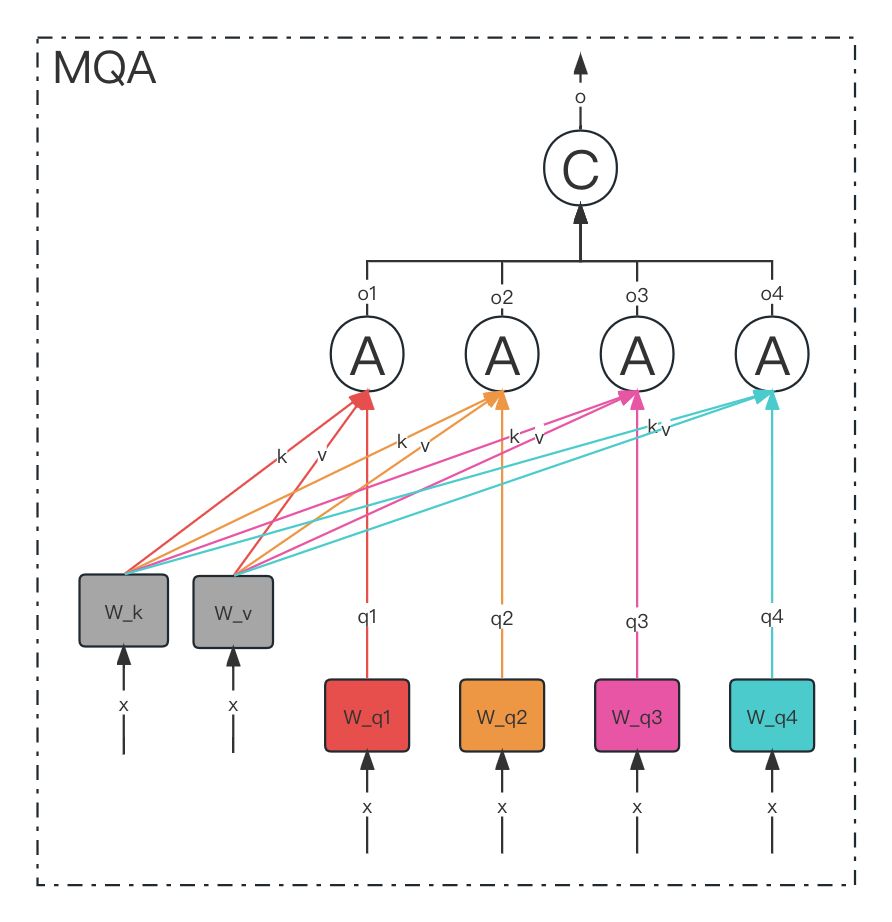

In [4]:
class MQA(nn.Module):
    def __init__(self, hidden_size, num_heads, p_dropout=0.1):
        super().__init__()
        assert hidden_size % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads  # 每个头的维度，二者必须整除
        
        #! 初始化 Q、K、V 投影矩阵，注意这里的 K V的输出维度不再是`hidden_size`而是`head_dim`
        self.w_q = nn.Linear(hidden_size, hidden_size)
        self.w_k   = nn.Linear(hidden_size, self.head_dim) 
        self.w_v = nn.Linear(hidden_size, self.head_dim)
        self.w_out = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(p=p_dropout)

    def forward(self, hidden_states, mask=None):
        # hidden_states 形状: (batch_size, seq_len, hidden_size)
        
        batch_size, seq_len, _ = hidden_states.size()       # 获取 hidden_size, batch_size
        
        # 线性变换
        query = self.split_head(hidden_states)              # (batch_size, num_heads, seq_len, head_dim)
        key = self.split_head(hidden_states, num_heads=1)   # (batch_size, 1, seq_len, head_dim)
        value = self.split_head(hidden_states, num_heads=1) # (batch_size, 1, seq_len, head_dim)
        
        # attention_scores 形状: (batch_size, num_heads, seq_len, seq_len)
        scores = query @ key.transpose(-1, -2) / math.sqrt(self.head_dim) 
        
        # attention mask
        # 添加注意力掩码（seq_len, seq_len），掩码位置（0）的值为负无穷
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # softmax
        # 对注意力分数进行归一化，得到注意力概率
        p_attn = scores.softmax(dim=-1)  # (batch_size, num_heads, seq_len, seq_len)
        p_attn = self.dropout(p_attn)    # dropout
        
        # qkv
        # 计算注意力输出，通过注意力概率加权值
        x = p_attn @ value
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(batch_size, -1, self.head_dim * self.num_heads)
        )
        # x = x.permute(0, 2, 1, 3).contiguous()
        
        del query, key, value
        
        return self.w_out(x)
    
    def split_head(self, x, num_heads=None):
        # 1.将单头映射到多头 2.完成维度的转换
        batch_size = x.size(0)  # 获取批量大小
        if num_heads is None:
            num_heads = self.num_heads  # 默认使用类中的 num_heads
        
        # 返回形状: (batch_size, head_num, seq_len, head_dim)
        return x.reshape(batch_size, -1, num_heads, self.head_dim).transpose(1, 2)


def test_attn():
    batch_size = 8
    seq_len = 32
    hidden_size = 64
    
    hidden_states = torch.randn(batch_size, seq_len, hidden_size)  # (batch_size, seq_len, hidden_size)

    sdpa = MQA(hidden_size, 8)
    output = sdpa(hidden_states)
    
    print("hidden_states shape:", hidden_states.shape)
    print("Output shape:", output.shape)
    
test_attn()

hidden_states shape: torch.Size([8, 32, 64])
Output shape: torch.Size([8, 32, 64])


### MQA

MQA的思想其实比较简单，MQA 与 MHA 不同的是，MQA 让所有的头之间共享同一份 Key 和 Value 矩阵，每个头正常的只单独保留了一份 Query 参数，从而大大减少 Key 和 Value 矩阵的参数量。[代码参考](https://hwcoder.top/Manual-Coding-1)

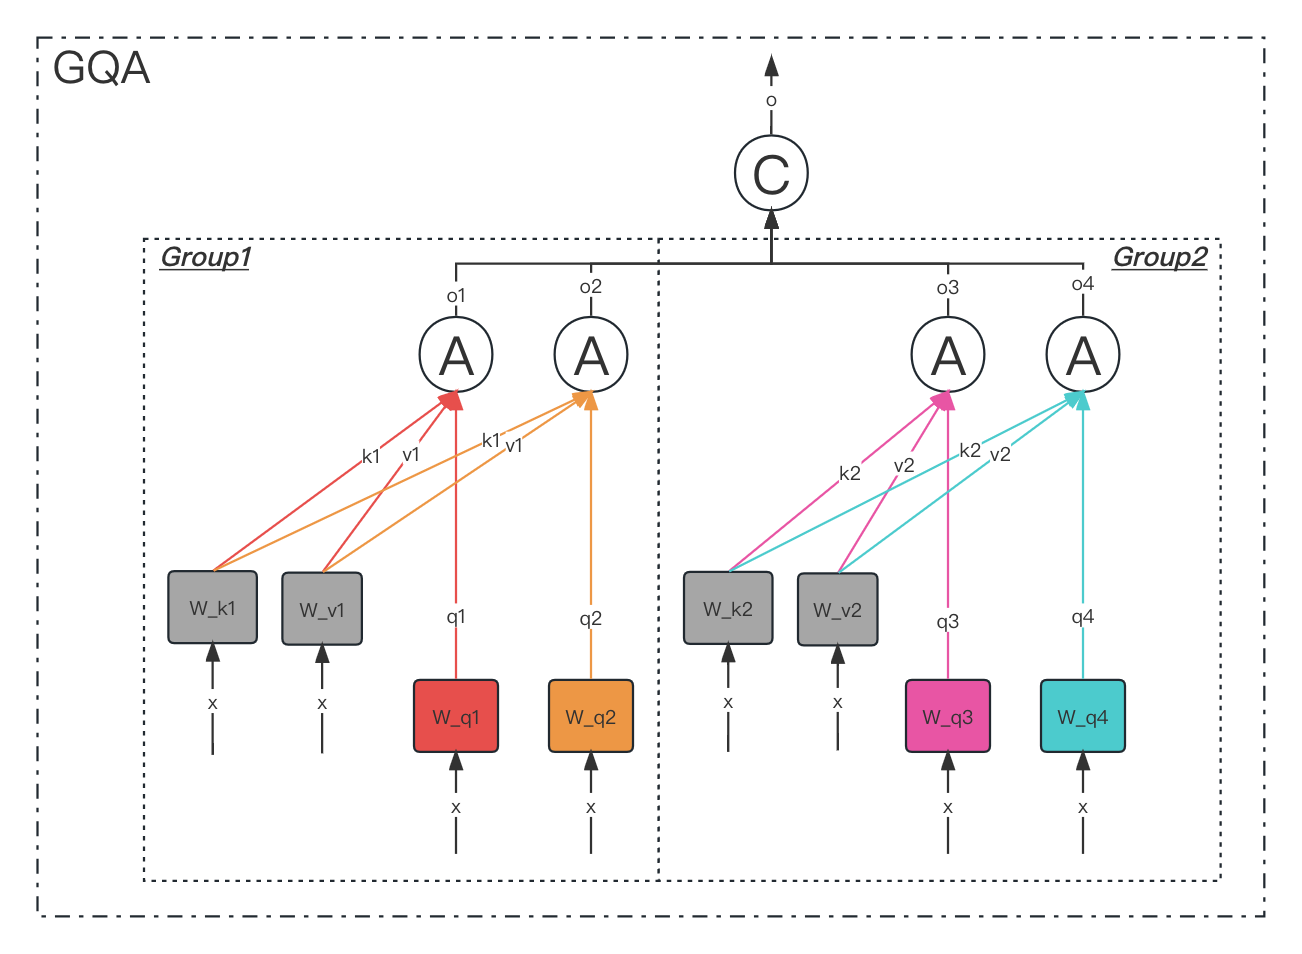

In [ ]:
class MQA(nn.Module):
    def __init__(self, hidden_size, num_heads, group_num, p_dropout=0.1):
        super().__init__()
        assert hidden_size % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads 
        self.group_num = group_num  # 组的数量
        
        #! 初始化 Q、K、V 投影矩阵，注意这里的 K V的输出维度不再是`hidden_size`而是`group_num * head_dim`
        self.w_q = nn.Linear(hidden_size, hidden_size)
        self.w_k   = nn.Linear(hidden_size, self.group_num * self.head_dim) 
        self.w_v = nn.Linear(hidden_size, self.group_num * self.head_dim)
        self.w_out = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(p=p_dropout)

    def forward(self, hidden_states, mask=None):
        # hidden_states 形状: (batch_size, seq_len, hidden_size)
        
        batch_size, seq_len, _ = hidden_states.size()       # 获取 hidden_size, batch_size
        
        # 线性变换
        query = self.split_head(hidden_states)                  # (batch_size, num_heads, seq_len, head_dim)
        key = self.split_head(hidden_states, self.group_num)    # (batch_size, num_heads, seq_len, head_dim)
        value = self.split_head(hidden_states, self.group_num)  # (batch_size, num_heads, seq_len, head_dim)
        
        # attention_scores 形状: (batch_size, num_heads, seq_len, seq_len)
        scores = query @ key.transpose(-1, -2) / math.sqrt(self.head_dim) 
        
        # attention mask
        # 添加注意力掩码（seq_len, seq_len），掩码位置（0）的值为负无穷
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # softmax
        # 对注意力分数进行归一化，得到注意力概率
        p_attn = scores.softmax(dim=-1)  # (batch_size, num_heads, seq_len, seq_len)
        p_attn = self.dropout(p_attn)    # dropout
        
        # qkv
        # 计算注意力输出，通过注意力概率加权值
        x = p_attn @ value
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(batch_size, -1, self.head_dim * self.num_heads)
        )
        # x = x.permute(0, 2, 1, 3).contiguous()
        
        del query, key, value
        
        return self.w_out(x)
    
    def split_head(self, x, group_num=None):
        batch_size, seq_len = x.size()[:2]  # 获取批量大小和序列长度
        
        if group_num is None:
            return x.reshape(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        else:
            # 将 hidden_size 分割为 group_num 和 head_dim
            x = x.reshape(batch_size, -1, group_num, self.head_dim).transpose(1, 2)
            # 再将其手动 expand 到相同大小
            x = x[:, :, None, :, :].expand(batch_size, group_num, self.num_heads // group_num, seq_len, self.head_dim).reshape(batch_size, self.num_heads, seq_len, self.head_dim)
            return x 	# 形状: (batch_size, num_heads, seq_len, head_dim)


def test_attn():
    batch_size = 8
    seq_len = 32
    hidden_size = 64
    
    hidden_states = torch.randn(batch_size, seq_len, hidden_size)  # (batch_size, seq_len, hidden_size)

    sdpa = MQA(hidden_size, 8)
    output = sdpa(hidden_states)
    
    print("hidden_states shape:", hidden_states.shape)
    print("Output shape:", output.shape)
    
test_attn()